# Basics: Spherical harmonic maps
Here we'll discuss how to instantiate spherical harmonic maps, plot them, rotate them, and compute phase curves and occultation light curves.

## Introduction
A *spherical harmonic map* is a vector of spherical harmonic coefficients, indexed by increasing degree $l$ and order $m$:

$y = \{Y_{0,0}, \, Y_{1,-1}, \, Y_{1,0}, \, Y_{1,1} \, Y_{2,-2}, \, Y_{2,-1}, \, Y_{2,0} \, Y_{2,1}, \, Y_{2,2}, \, ...\}$.

For reference, here's what the first several spherical harmonic degrees look like:

![](ylms.png)

Each row corresponds to a different degree $l$, starting at $l = 0$. Within each row, the harmonics extend from order $m = -l$ to order $m = l$. Together, the spherical harmonics form a complete basis set on the sphere, so in principle *any surface map* can be expanded in terms of these functions.

As an example, suppose we have the following map vector:

```
y = [1.00,  0.22,  0.19,  0.11,  0.11,  0.07,  -0.11, 0.00,  -0.05,
     0.12,  0.16,  -0.05, 0.06,  0.12,  0.05,  -0.10, 0.04,  -0.02,
     0.01,  0.10,  0.08,  0.15,  0.13,  -0.11, -0.07, -0.14, 0.06,
     -0.19, -0.02, 0.07,  -0.02, 0.07,  -0.01, -0.07, 0.04,  0.00]
```

This is how much each spherical harmonic is contributing to the sum:

![](ylms_earth.png)

If we add up all of the terms, we get the following image:

![](earth5.png)

which is the $l = 5$ spherical harmonic expansion of a map of the Earth! South America is to the left and Africa is toward the top right. It might still be hard to see, so here's what we would get if we carried the expansion up to degree $l = 20$:

![](earth20.png)

Before we dig into the code, one final cool thing about spherical harmonics is that they can be rotated, which makes them ideal for modeling planets, stars, and other celestial bodies:

![](earth.gif)

## Using `starry`
OK, now that we've introduced the spherical harmonics, let's look at how we can use `starry` to model some celestial bodies.

The first thing we should do is import `starry` and instantiate a `Map` object. This is the simplest way of creating a spherical harmonic map. The `Map` object takes a few arguments, the most important of which is `lmax`, the highest degree of the spherical harmonics used to describe the map. Let's create a fifth-order map:

In [ ]:
%matplotlib inline

In [1]:
import starry
map = starry.Map(lmax=5)

The `y` attribute of the map stores the spherical harmonic coefficients. We can see that our map is initialized to a constant map: 

In [2]:
map.y

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

By default, the $Y_{0,0}$ coefficient is set to unity, and all other coefficients are set to zero. Our map is therefore just the first spherical harmonic, which if you scroll up you'll see is that constant dark blue disk at the top of the first figure. We can also quickly visualize the map by calling the `show` method:

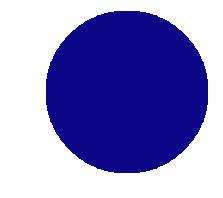

In [4]:
map.show()

Not that interesting! But before we give this map some features, let's briefly discuss how we would *evaluate* our map. This means computing the intensity at a point on the surface. We can do this simply by calling the map object and passing an $xy$ coordinate. Let's investigate the intensity at the center of the map:

In [4]:
map(x=0, y=0)

0.31830988618379064

Since our map is constant, this is the intensity everywhere on the surface. It may seem like a strange number, but perhaps it will make sense if compute what the total *flux* (intensity integrated over area) of the map is. Since the map is constant, and since the body we're modeling has unit radius by default, the total flux visible to the observer is just...

In [5]:
import numpy as np
np.pi * 1.0 ** 2 * map(x=0, y=0)

0.9999999999999999

So the total flux visible from the map is [unity](https://en.wikipedia.org/wiki/0.999...). **This is how maps in** `starry` **are normalized:** the average disk-integrated intensity is equal to the coefficient of the constant $Y_{0,0}$ harmonic, which by default is unity. We're going to discuss in detail how to compute fluxes below, but here's a sneak peek:

In [6]:
map.flux()

1.0

Given zero arguments, the `flux` method of the map returns the total visible flux from the map, which as we showed above, is just unity.

## Setting map coefficients

Okay, onto more interesting things. Setting spherical harmonic coefficients is extremely easy: we can assign values directly to the map instance itself. Say we wish to set the coefficient of the spherical harmonic $Y_{5, -3}$ to $-2$. We simply run

In [7]:
map[5, -3] = -2

We can check that the spherical harmonic vector (which is a flattened version of the image we showed above) has been updated accordingly:

In [8]:
map.y

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

And here's what our map now looks like:

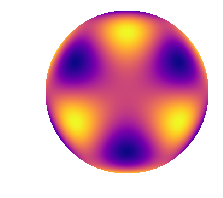

In [9]:
map.show()

Just for fun, let's set two additional coefficients:

In [10]:
map[5, 0] = 2
map[5, 4] = 1

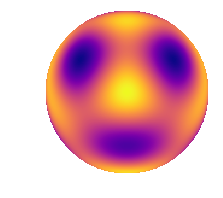

In [11]:
map.show()

Kind of looks like a smiley face!

**Pro tip:** *To turn your smiley face into a Teenage Mutant Ninja Turtle, simply edit the* $Y_{5,2}$ *coefficient:*

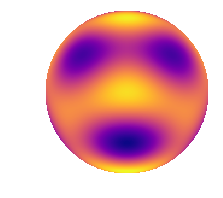

In [12]:
map[5, 2] = 1.5
map.show()

It's probably useful to play around with setting coefficients and plotting the resulting map to get a feel for how the spherical harmonics work. One last note on visualizing maps: you can quickly animate the map by setting the map's rotation axis,

In [13]:
map.axis = [0, 1, 0]

(in this case, $\hat{y}$) and calling the `animate` method:

In [14]:
map.animate()

Unfortunately, the back of our turtle's head doesn't look very flattering.

## Rotating maps

Before we get into light curve computation, there's one last thing we should know how to do, and that's apply rotations to maps. There are some very cool theorems that allow us to efficiently rotate spherical harmonics, so it's quite easy to rotate a map around an arbitrary axis in 3D space. The animation above shows a series of rotations about $\hat{y}$, but what if we want to actually rotate our map to an arbitrary orientation so that we can, say, compute its occultation light curve? Let's use the Ninja Turtle example from above:

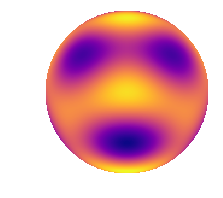

In [15]:
map.show()

In order to rotate it about a given axis, first we set the map's `axis` attribute:

In [16]:
map.axis = [1, 0.5, 0]

This is the vector $\vec{u} = \hat{x} + \frac{1}{2}\hat{y}$, which kind of points up and to the right in the plane of the sky. You'll notice that the vector we provided is *not normalized* (the sum of the squares of the coefficients is larger than unity), but `starry` took care of that for us behind the scenes:

In [17]:
map.axis

array([0.89442719, 0.4472136 , 0.        ])

Now, we can rotate the base map about this axis by typing

In [18]:
map.rotate(30)

where we specified a rotation angle of $30^\circ$. Rotations in `starry` are always *counter-clockwise*, so this will rotate the map downward and slightly to the right. Here's what our new map looks like:

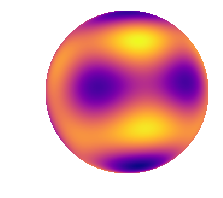

In [19]:
map.show()

We can see that all the coefficients changed:

In [20]:
map.y

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.05834848, -0.81246327, -1.01864456, -0.20234431, -0.81325047,
       -0.96966288,  0.9931561 , -2.18775807, -0.63423012, -1.23104511,
       -0.46468504])

Rotations of spherical harmonics operate on each degree independently: note how only the $l = 5$ coefficients were affected.

## Computing phase curves
We've seen how to instantiate and manipulate maps, but what we really would like to do is compute light curves. So let's get to it. Everything we need is in the `flux` method:

```python
def flux(self, theta=0, xo=0, yo=0, ro=0, gradient=False, numerical=False):
    ...
```

As before, `theta` defines the rotation angle of the map. The parameters `xo`, `yo`, and `ro` define the location and size of the occulting body (if any) relative to the `Map` object. `xo` and `yo` are the location of the center of the occultor and `ro` is its radius, all measured in units of the `Map` object's radius (=1). By the way, `theta`, `xo`, `yo`, and `ro` can all be either scalars or vectors. If more than one is a vector, their sizes must (obviously) match.

To start, let's simply compute some phase curves, with no occultations. Let's operate on our Ninja Turtle map:

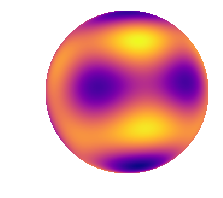

In [21]:
map.show()

We will compute one full cycle of the phase curve by varying `theta` between 0 and 360 degrees. For simplicity, let's pick $\hat{y}$ as our rotation axis.

In [22]:
theta = np.linspace(0, 360, 100, endpoint=False)
map.axis = [0, 1, 0]

Computing the phase curve is super easy:

In [23]:
F = map.flux(theta=theta)

Plot the results:

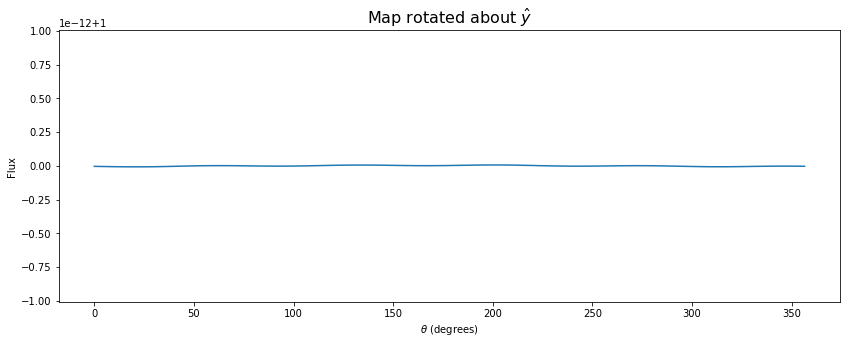

In [24]:
import matplotlib.pyplot as pl
%matplotlib inline
fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(theta, F);
ax.set_xlabel(r'$\theta$ (degrees)');
ax.set_ylabel(r'Flux');
ax.set_title(r'Map rotated about $\hat{y}$', fontsize=16);

Wait a minute... Where's the phase curve? There seems to be something there, but look at the scale: the variations are on the order of $10^{-15}$, which is close to machine epsilon. As it happens, our map has odd degree $l$, which means it's actually in the null space for rotations about $\hat{y}$ and $\hat{x}$! As the map rotates and a region of high flux comes into view, there's a region of low flux rotating out of view that perfectly cancels out the signal. This is a curious property of the odd $l > 1$ spherical harmonics, so our Ninja Turtle does in fact have no phase curve!

In [25]:
map.animate()

What we can do to get a phase curve signal is add some power to the even degrees:

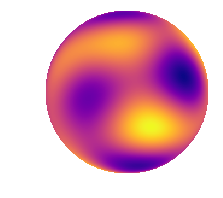

In [26]:
map[2, 2] = -0.3
map[4, 0] = 1
map[4, -2] = -2
map.show()

Sadly, it no longer looks like a Ninja Turtle. But let's rotate this new map about each of the three principal axes and see what we get:

In [27]:
# xhat
map.axis = [1, 0, 0]
Fx = map.flux(theta=theta)

# yhat
map.axis = [0, 1, 0]
Fy = map.flux(theta=theta)

# zhat
map.axis = [0, 0, 1]
Fz = map.flux(theta=theta)

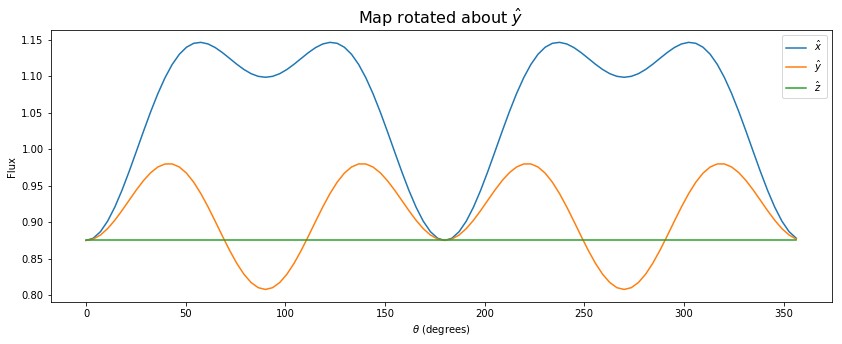

In [28]:
fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(theta, Fx, label=r"$\hat{x}$");
ax.plot(theta, Fy, label=r"$\hat{y}$");
ax.plot(theta, Fz, label=r"$\hat{z}$");
ax.set_xlabel(r'$\theta$ (degrees)');
ax.set_ylabel(r'Flux');
ax.legend();
ax.set_title(r'Map rotated about $\hat{y}$', fontsize=16);

Cool! Note that rotation about $\hat{z}$ never yields a phase curve, since that's a rotation about the line of sight, which cannot change the integrated intensity. Just for fun, here are animations of the three rotations we applied:

In [29]:
map.axis = [1, 0, 0]
map.animate()

In [30]:
map.axis = [0, 1, 0]
map.animate()

In [31]:
map.axis = [0, 0, 1]
map.animate()

## Computing occultation light curves

Finally, we're ready to discuss occultation light curves! Let's occult the map we created with a small occultor and compute the resulting light curve.

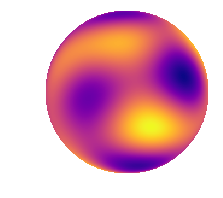

In [32]:
map.show()

Consider an occultor of radius $r_o = 0.1$ moving along the $+x$ direction at $y_o = -0.5$. Suppose that the occulted body rotates by $30^\circ$ about the $y$-axis in the meantime. Let's define our variables:

In [33]:
npts = 100
ro = 0.1
xo = np.linspace(-3, 3, npts)
yo = -0.5
theta = np.linspace(0, 30, npts, endpoint=False)
map.axis = [0, 1, 0]

Computing the occultation light curve is now easy:

In [34]:
F = map.flux(theta=theta, xo=xo, yo=yo, ro=ro)

Here's the rather odd-looking light curve:

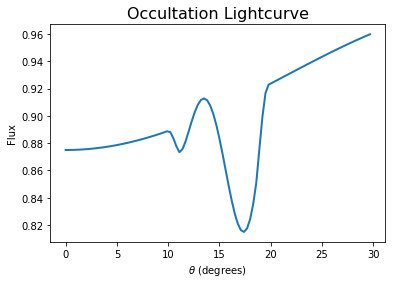

In [35]:
fig, ax = pl.subplots(1)
ax.plot(theta, F, lw=2);
ax.set_xlabel(r'$\theta$ (degrees)');
ax.set_ylabel(r'Flux');
ax.set_title(r'Occultation Lightcurve', fontsize=16);

The occultor first blocks the bright yellow region near the limb at the left, causing the first big dip. It then occults the very dark region at the bottom center of the map, causing the bump in the light curve (the intensity there is actually *negative* -- oops! -- so the light curve gets *brighter* with the occultor in place). Finally, it occults the bright yellow region at the right. All this while the occulted body is rotating, and its phase curve signature is evident.

That's it for now! There's a lot more you can do with `starry`, so be sure to check out the other tutorials!